In [2]:
import os
import os.path

import matplotlib.pyplot as plt
import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

In [3]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)](https://arxiv.org/pdf/1602.05473.pdf).
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = torch.linspace(0, 2*torch.pi, num_classes + 1)

    features = torch.randn(num_classes*num_per_class, 2) * torch.tensor([radial_std, tangential_std])
    print(features)
    features[:, 0] = features[:, 0] + 1.0
    labels = torch.repeat_interleave(torch.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * torch.exp(features[:,0])
    rotations = torch.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = torch.reshape(rotations.T, (-1, 2, 2))

    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], torch.einsum('ti,tij->tj', features, rotations)[perm_ix]

tensor([[-0.2434,  0.1953],
        [-0.3561, -0.0344],
        [ 0.0598, -0.1098],
        ...,
        [-0.7799,  0.1188],
        [-0.2639,  0.0747],
        [ 0.2303, -0.0071]])


(-1.8210932731628418,
 1.43893404006958,
 -1.9577015876770019,
 1.4966360569000243)

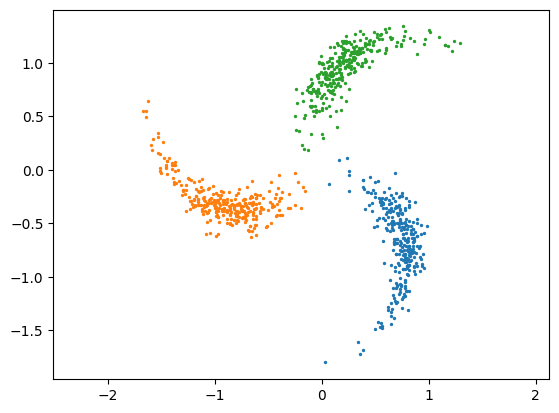

In [4]:
num_clusters = 3           
samples_per_cluster = 300
labels, data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from vae import diag_gaussian_log_density, diag_gaussian_samples, diag_gaussian_logpdf, log_prior, batch_elbo
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because 
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

/tmp/ipykernel_2923948/3367293883.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  1%|          | 24/2000 [00:00<00:08, 239.16it/s]

Iteration 0 lower bound -51.6627082824707


  7%|▋         | 139/2000 [00:00<00:06, 281.47it/s]

Iteration 100 lower bound -2.9059813022613525


 13%|█▎        | 255/2000 [00:00<00:06, 285.34it/s]

Iteration 200 lower bound -1.5434849262237549


 17%|█▋        | 342/2000 [00:01<00:05, 286.15it/s]

Iteration 300 lower bound -2.3498125076293945


 23%|██▎       | 458/2000 [00:01<00:05, 286.50it/s]

Iteration 400 lower bound -1.9304112195968628


 27%|██▋       | 545/2000 [00:01<00:05, 286.50it/s]

Iteration 500 lower bound -2.307283639907837


 32%|███▏      | 632/2000 [00:02<00:04, 286.33it/s]

Iteration 600 lower bound -1.7045886516571045


 37%|███▋      | 748/2000 [00:02<00:04, 286.84it/s]

Iteration 700 lower bound -1.9829360246658325


 42%|████▏     | 835/2000 [00:02<00:04, 285.65it/s]

Iteration 800 lower bound -2.081713914871216


 48%|████▊     | 951/2000 [00:03<00:03, 283.95it/s]

Iteration 900 lower bound -1.373315453529358


 52%|█████▏    | 1038/2000 [00:03<00:03, 284.70it/s]

Iteration 1000 lower bound -1.330672264099121


 58%|█████▊    | 1154/2000 [00:04<00:02, 285.88it/s]

Iteration 1100 lower bound -2.687540054321289


 62%|██████▏   | 1234/2000 [00:04<00:03, 227.23it/s]

Iteration 1200 lower bound -1.7151952981948853


 67%|██████▋   | 1349/2000 [00:04<00:02, 267.11it/s]

Iteration 1300 lower bound -2.1477177143096924


 72%|███████▏  | 1435/2000 [00:05<00:02, 276.68it/s]

Iteration 1400 lower bound -0.15813198685646057


 78%|███████▊  | 1551/2000 [00:05<00:01, 280.91it/s]

Iteration 1500 lower bound -0.8473543524742126


 82%|████████▏ | 1638/2000 [00:05<00:01, 281.70it/s]

Iteration 1600 lower bound -1.807081937789917


 88%|████████▊ | 1754/2000 [00:06<00:00, 281.96it/s]

Iteration 1700 lower bound -0.8427965044975281


 92%|█████████▏| 1841/2000 [00:06<00:00, 281.38it/s]

Iteration 1800 lower bound -2.5354559421539307


 98%|█████████▊| 1957/2000 [00:07<00:00, 281.21it/s]

Iteration 1900 lower bound 0.818877637386322


100%|██████████| 2000/2000 [00:07<00:00, 277.82it/s]


torch.Size([300, 2])
torch.Size([300, 2])
torch.Size([300, 2])


Text(0, 0.5, 'latent dimension 2')

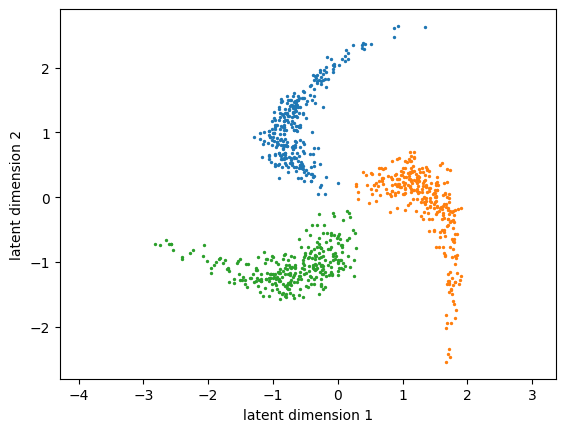

In [6]:
for k in range(num_clusters):
    cur_data = data[labels == k] 
    transformed = recognition_net.forward(cur_data)[0].detach()
    
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

    print(transformed.shape)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

(-4.208206522464752, 3.7575265049934385, -6.15903023481369, 2.676708257198334)

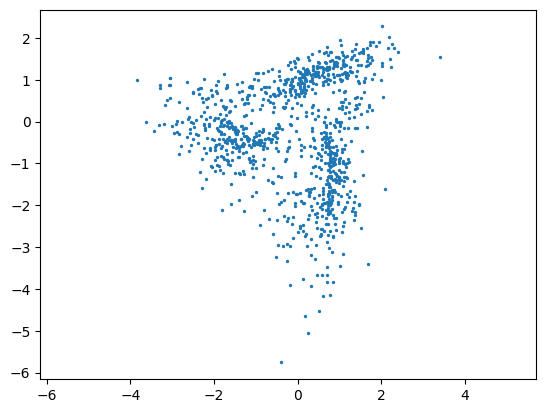

In [7]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1000
samples =  diag_gaussian_samples(torch.zeros(latent_dimension), torch.ones(latent_dimension), num_samples)
transformed =  decoder_net(samples)[0].detach()

plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")